<a href="https://colab.research.google.com/github/mc-ivan/zero-shot/blob/main/lab3/notebooks/Practica3_Grupo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 3: Clasificación Zero-Shot con CLIP para Inventario y Organización Doméstica
**CASO: LIVING ROOM**

**Grupo 3**
- Ivan Mamani
- Yesica Luna
- Elvis Miranda

**Dataset creado:** https://app.roboflow.com/mciai/livingroom-catalog/1

---

In [2]:
# Instalamos CLIP y librerías necesarias
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install roboflow pandas pillow requests matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vvjydm5u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vvjydm5u
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=071739231b2031df059a8b5c270a0b25994284aa40d6c9eff0f7ab7dc910ac81
  Stored in directory: /tmp/pip-ephem-wheel-cache-hva1_yxr/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.3

In [12]:
# Importando librerias
import torch
import clip
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from roboflow import Roboflow
import pandas as pd
from pathlib import Path


In [13]:
# Seleccionamos GPU si existe
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargamos modelo CLIP preentrenado
model, preprocess = clip.load("ViT-B/32", device=device)

# Ponemos el modelo en modo evaluación
model.eval()

print(f"CLIP cargado correctamente en device: {device}")


CLIP cargado correctamente en device: cuda


In [ ]:
# Datos del dataset de roboflow
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="DQv0akyzHYegEmXrUS5l")
# project = rf.workspace("mciai").project("livingroom-catalog")
# version = project.version(1)
# dataset = version.download("openai")


In [14]:
# Dataset de Roboflow
API_KEY = "DQv0akyzHYegEmXrUS5l"

# Datos del proyecto
WORKSPACE = "mciai"
PROJECT = "livingroom-catalog"
VERSION = 1

# Conexión con Roboflow
rf = Roboflow(api_key=API_KEY)
project = rf.workspace(WORKSPACE).project(PROJECT)
dataset = project.version(VERSION).download("jsonl")

print("\nDataset descargado en:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...

Dataset descargado en: /content/LivingRoom-Catalog-1


In [15]:
# Lista donde guardaremos los pares imagen-texto
pairs = []

# Roboflow divide automáticamente el dataset en train / valid / test
splits = ["train", "valid", "test"]

for split in splits:

    # Ruta hacia cada split (train, valid o test)
    split_path = Path(dataset.location) / split

    # Buscamos el archivo annotations.jsonl dentro del split
    jsonl_files = list(split_path.glob("*.jsonl"))

    print(f"\nLeyendo split: {split}")
    print("JSONL encontrados:", len(jsonl_files))

    # Cada JSONL contiene las descripciones textuales
    for file in jsonl_files:
        with open(file, "r") as f:

            # Leemos línea por línea (cada línea es una imagen + caption)
            for line in f:

                # Convertimos la línea en un objeto JSON
                obj = json.loads(line)

                # Extraemos:
                # - nombre de la imagen
                # - descripción textual (prompt)
                image_name = obj.get("image")
                caption = obj.get("suffix")

                # Solo seguimos si ambos existen
                if image_name and caption:

                    # Posibles rutas donde puede estar la imagen
                    possible_paths = [
                        split_path / image_name,            # directamente en la carpeta
                        split_path / "images" / image_name  # dentro de /images
                    ]

                    # Buscamos cuál de las rutas realmente existe
                    img_path = next((p for p in possible_paths if p.exists()), None)

                    # Si encontramos la imagen, guardamos el par
                    if img_path:
                        pairs.append({
                            "image_path": str(img_path),  # ruta completa de la imagen
                            "text": caption               # descripción textual
                        })

# Convertimos la lista en un DataFrame para trabajar fácilmente
df = pd.DataFrame(pairs)

# Mostramos cuántos pares imagen-texto cargamos
print("\nTotal pares cargados:", len(df))

# Vista previa del dataset cargado
df.head()



Leyendo split: train
JSONL encontrados: 1

Leyendo split: valid
JSONL encontrados: 1

Leyendo split: test
JSONL encontrados: 0

Total pares cargados: 55


,image_path,text
0,/content/LivingRoom-Catalog-1/train/mesa_5_png...,A household table situated in a living room en...
1,/content/LivingRoom-Catalog-1/train/alfombra_1...,A soft rug placed on the floor of a living roo...
2,/content/LivingRoom-Catalog-1/train/libro_3_pn...,A stack of reading materials located in a livi...
3,/content/LivingRoom-Catalog-1/train/tv_5_png.r...,A television set used for entertainment inside...
4,/content/LivingRoom-Catalog-1/train/tv_4_png.r...,A media display device situated in a living room.


Caption real: A floor lamp positioned inside a living room.


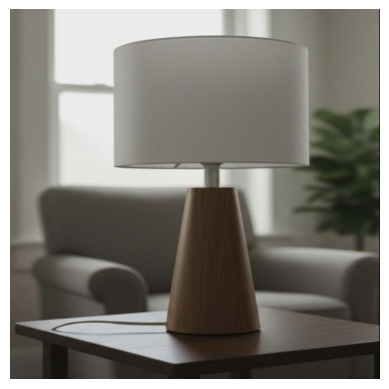

In [25]:
# Elegimos una imagen cualquiera del dataset
index = 10  # podemmos cambiar para probar

test_image = Image.open(df.loc[index, "image_path"]).convert("RGB")
true_text = df.loc[index, "text"]

print("Caption real:", true_text)

plt.imshow(test_image)
plt.axis("off")
plt.show()


In [26]:
# Usamos todos los captions únicos como posibles clases
candidate_texts = df["text"].unique().tolist()

# Limitar si hay muchos (opcional)
candidate_texts = candidate_texts[:50]

print("Total textos candidatos:", len(candidate_texts))


Total textos candidatos: 50


In [27]:
# Tokenizamos los textos
text_tokens = clip.tokenize(candidate_texts).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()

    # Normalizamos vectores
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [28]:
# Preprocesamos imagen
image_input = preprocess(test_image).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()

    # Normalizamos
    image_features /= image_features.norm(dim=-1, keepdim=True)


In [29]:
# Similaridad imagen-texto
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

probs = similarity.cpu().numpy().flatten()


In [30]:
# Número de predicciones más probables que queremos mostrar
top_k = 8

# Ordenamos las probabilidades de mayor a menor
# argsort() ordena de menor a mayor → por eso usamos [::-1] para invertir
# Luego tomamos solo las top_k mejores coincidencias
top_indices = probs.argsort()[::-1][:top_k]

print("\nTop predicciones:")

# Recorremos los índices de las mejores coincidencias
for idx in top_indices:

    # Mostramos:
    # - la probabilidad asignada por CLIP
    # - el texto (prompt) que mejor describe la imagen según el modelo
    print(f"{probs[idx]:.4f} -> {candidate_texts[idx]}")



Top predicciones:
0.5077 -> A standing lamp providing light in a living room.
0.2647 -> A household lamp placed near furniture in a living room.
0.1843 -> A floor lamp positioned inside a living room.
0.0235 -> A decorative lamp situated inside a home living area.
0.0084 -> A lighting fixture located within a domestic living space.
0.0037 -> A handheld remote placed on a sofa or table inside a living room environment.
0.0021 -> A beverage container positioned on a surface in a living room.
0.0013 -> A media display device situated in a living room.


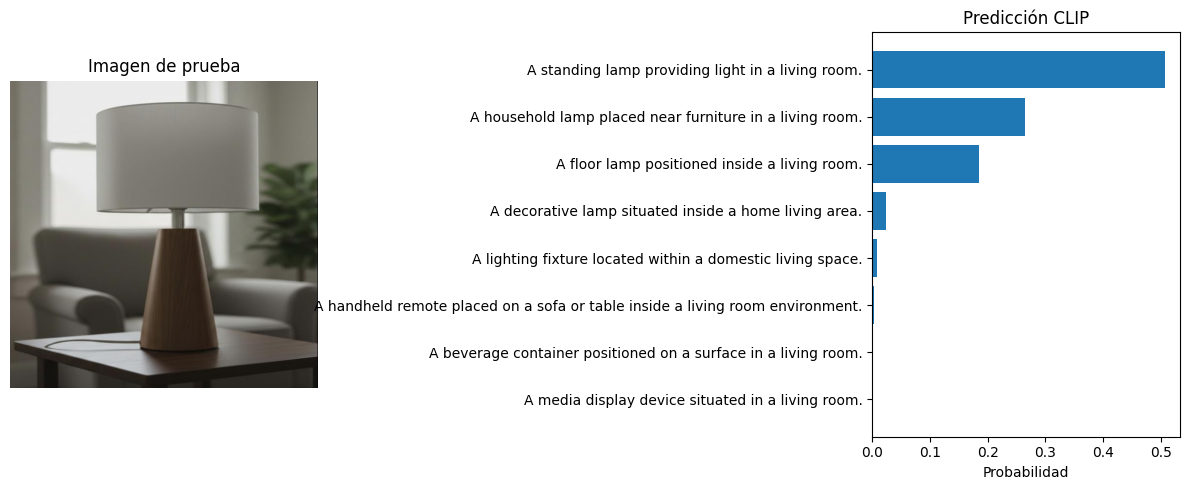

In [31]:
# Extraemos los textos correspondientes a las mejores predicciones
# [::-1] se usa para invertir el orden y que el mayor valor aparezca arriba en la gráfica
top_labels = [candidate_texts[i] for i in top_indices][::-1]

# Extraemos las probabilidades asociadas a esas predicciones
# También se invierte el orden para que coincida visualmente con las etiquetas
top_probs = [probs[i] for i in top_indices][::-1]

# Creamos una figura con tamaño horizontal
plt.figure(figsize=(12,5))

# ----- Subplot 1: Imagen de prueba -----
plt.subplot(1,2,1)
plt.imshow(test_image)     # Mostramos la imagen analizada
plt.axis("off")            # Ocultamos los ejes
plt.title("Imagen de prueba")

# ----- Subplot 2: Resultados del modelo -----
plt.subplot(1,2,2)

# Creamos posiciones numéricas para el eje Y
y = np.arange(len(top_labels))

# Graficamos barras horizontales con las probabilidades
plt.barh(y, top_probs)

# Asignamos las etiquetas (descripciones) al eje Y
plt.yticks(y, top_labels)

# Etiqueta del eje X
plt.xlabel("Probabilidad")

# Título del gráfico
plt.title("Predicción CLIP")

# Ajusta automáticamente el espacio entre gráficos
plt.tight_layout()

# Muestra la visualización final
plt.show()
